# AI-Compass Benchmarking Analysis (v1)

This notebook performs the clustering analysis for the AI-Compass benchmarking tool.
It uses a **5-Cluster K-Means Model** to segment companies based on their maturity across 7 dimensions.

**Scoring Method**: Weighted average with proper scaling:
- Checklist questions: Sum weights (max 100) → scale to 1-5 → apply question weight
- Standard questions: Answer weight → apply question weight  
- Dimension scores: Weighted average across questions (max score = 5)

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add current directory to path to allow importing local modules
sys.path.append(os.getcwd())

from data_pipeline import DataPipeline
from models import ClusterEngine

%matplotlib inline

## 1. Load Data
Fetching data from the PostgreSQL database and converting it into a Feature Matrix.

In [2]:
dp = DataPipeline()
dfs = dp.fetch_data()

if dfs:
    q_matrix, d_matrix, meta = dp.create_matrices(dfs)
    print(f"Loaded {len(d_matrix)} companies.")
    print(f"Dimensions: {list(d_matrix.columns)}")
    print(f"\nDimension Score Range: {d_matrix.min().min():.2f} - {d_matrix.max().max():.2f}")
    
    # Store dimension columns for later use
    dimension_cols = list(d_matrix.columns)
else:
    print("Failed to load data. Check DB connection.")

Loaded 500 companies.
Dimensions: ['Data Readiness & Literacy', 'Governance & Compliance', 'People & Culture', 'Processes & Scaling', 'Strategy & Business Vision', 'Tech Infrastructure', 'Use Cases & Business Value']

Dimension Score Range: 1.47 - 5.00


d:\SpicedProjects\Projects\ai-compass\benchmarking_ai\ml_v1\data_pipeline.py:143: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dim_results = dim_groups.apply(


## 2. Run Clustering (5 Clusters)
We use K-Means with `n_clusters=5`.

In [3]:
clust = ClusterEngine(d_matrix, n_clusters=5)
labels = clust.train()
results = clust.get_results_df()

## 3. Apply Logical Naming (1-5 Scale)
We remap the random Cluster IDs to a logical progression from **Laggards (1)** to **Leaders (5)**.

In [4]:
# REMAP IDs based on Centroid Analysis (Fixed for random_state=42)
id_remap = {
    4: 1, # Laggard
    1: 2, # Data-Rich / Tech-Poor
    0: 3, # Middle Pack
    2: 4, # Tech Specialists
    3: 5  # Leaders
}
results['Cluster'] = results['Cluster'].map(id_remap)

new_cluster_names = {
    1: "1 - Laggards",
    2: "2 - Data-Rich / Tech-Poor",
    3: "3 - Middle Pack",
    4: "4 - Tech Specialists",
    5: "5 - Leaders"
}
results['Cluster_Name'] = results['Cluster'].map(new_cluster_names)

print("Company segments:")
print(results['Cluster_Name'].value_counts().sort_index())

Company segments:
Cluster_Name
1 - Laggards                  72
2 - Data-Rich / Tech-Poor     98
3 - Middle Pack               57
4 - Tech Specialists         200
5 - Leaders                   73
Name: count, dtype: int64


## 4. Visualization (PCA)
Plotting the clusters on the main Principal Components:
*   **X-Axis**: Strategic Maturity
*   **Y-Axis**: Technical Readiness

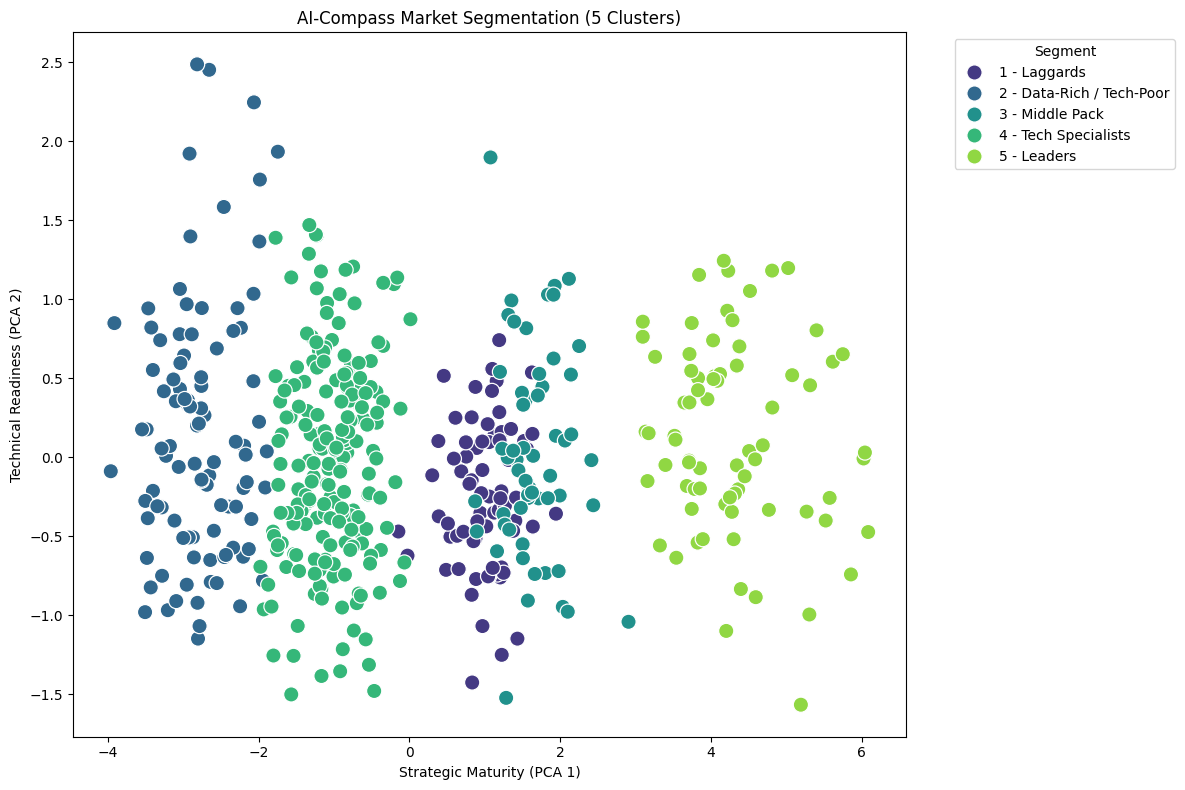

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results.sort_values('Cluster'), 
    x='PCA_X', 
    y='PCA_Y', 
    hue='Cluster_Name', 
    palette='viridis', 
    s=120
)
plt.title('AI-Compass Market Segmentation (5 Clusters)')
plt.xlabel('Strategic Maturity (PCA 1)')
plt.ylabel('Technical Readiness (PCA 2)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Cluster Interpretation
Examining the average scores for each cluster to understand their strengths and weaknesses.

**Note**: All scores are on a 1-5 scale using weighted averaging.

In [6]:
# Calculate centroids using ONLY dimension columns (exclude Cluster, PCA_X, PCA_Y)
centroids = results.groupby('Cluster_Name')[dimension_cols].mean()

print("--- Cluster Centroids (Mean Scores, 1-5 Scale) ---")
print(f"Score range: {centroids.min().min():.2f} - {centroids.max().max():.2f}")
print()
display(centroids.style.background_gradient(cmap='Greens', axis=None).format("{:.2f}"))

print("\n--- Detailed Breakdown ---")
for cluster_name, row in centroids.iterrows():
    sorted_dims = row.sort_values(ascending=False)
    top = sorted_dims.head(2)
    bottom = sorted_dims.tail(2)
    
    print(f"\n{cluster_name}:")
    print(f"  STRONG: {top.index[0]} ({top.iloc[0]:.2f}), {top.index[1]} ({top.iloc[1]:.2f})")
    print(f"  WEAK:   {bottom.index[0]} ({bottom.iloc[0]:.2f}), {bottom.index[1]} ({bottom.iloc[1]:.2f})")
    print(f"  Companies: {len(results[results['Cluster_Name'] == cluster_name])}")

--- Cluster Centroids (Mean Scores, 1-5 Scale) ---
Score range: 2.10 - 4.36



dimension_name,Data Readiness & Literacy,Governance & Compliance,People & Culture,Processes & Scaling,Strategy & Business Vision,Tech Infrastructure,Use Cases & Business Value
Cluster_Name,,,,,,,
1 - Laggards,2.52,3.56,3.35,3.37,3.45,2.79,3.37
2 - Data-Rich / Tech-Poor,2.10,2.35,2.16,2.23,2.19,2.26,2.19
3 - Middle Pack,2.94,3.71,3.43,3.44,3.36,3.20,3.45
4 - Tech Specialists,2.34,2.96,2.70,2.72,2.71,2.52,2.72
5 - Leaders,3.34,4.36,4.20,4.19,4.24,3.85,4.20



--- Detailed Breakdown ---

1 - Laggards:
  STRONG: Governance & Compliance (3.56), Strategy & Business Vision (3.45)
  WEAK:   Tech Infrastructure (2.79), Data Readiness & Literacy (2.52)
  Companies: 72

2 - Data-Rich / Tech-Poor:
  STRONG: Governance & Compliance (2.35), Tech Infrastructure (2.26)
  WEAK:   People & Culture (2.16), Data Readiness & Literacy (2.10)
  Companies: 98

3 - Middle Pack:
  STRONG: Governance & Compliance (3.71), Use Cases & Business Value (3.45)
  WEAK:   Tech Infrastructure (3.20), Data Readiness & Literacy (2.94)
  Companies: 57

4 - Tech Specialists:
  STRONG: Governance & Compliance (2.96), Use Cases & Business Value (2.72)
  WEAK:   Tech Infrastructure (2.52), Data Readiness & Literacy (2.34)
  Companies: 200

5 - Leaders:
  STRONG: Governance & Compliance (4.36), Strategy & Business Vision (4.24)
  WEAK:   Tech Infrastructure (3.85), Data Readiness & Literacy (3.34)
  Companies: 73
